In [154]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
#from scipy.signal import savgol_filter
import matplotlib.gridspec as gridspec
import os as os

path = "./results/"

In [155]:
def plot_evaluation_data(data_path, window_size=10):
    """
    Plots evaluation rewards and success over time, with optional smoothing.
    
    Parameters:
    - data_path (str): Path to the .npz data file.
    - window_size (int): The window size for smoothing (default is 10).
    """
    
    # Load the data
    loaded_data = np.load(data_path)
    time = loaded_data['Total_Time_List']  # Assuming this is in seconds
    rewards = loaded_data['Evaluation_Reward_List']
    success = loaded_data['Evaluation_Success_List']

    # Convert time to hours
    time_in_hours = time / 3600

    # Check if the number of data points is sufficient for smoothing
    num_data_points = len(rewards)
    if num_data_points < window_size:
        raise ValueError(f"Insufficient data points for smoothing: {num_data_points} points, but window size is {window_size}.")

    # Smoothing for rewards and success
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    padded_rewards = np.pad(smoothed_rewards, (window_size // 2, window_size - window_size // 2 - 1), mode='edge')

    smoothed_success = np.convolve(success, np.ones(window_size) / window_size, mode='valid')
    padded_success = np.pad(smoothed_success, (window_size // 2, window_size - window_size // 2 - 1), mode='edge')

    # Ensure the time array has the same length as rewards and success
    if len(time_in_hours) != len(rewards) or len(time_in_hours) != len(success):
        raise ValueError("Time array and rewards/success arrays lengths do not match.")

    # Create a figure with two subplots (one below the other)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Plot rewards on the first subplot
    ax1.plot(time_in_hours, rewards, label="Evaluation Rewards", color='blue', alpha=0.4)
    ax1.plot(time_in_hours, padded_rewards, label="Smoothed Rewards", color='orange')
    ax1.set_ylabel("Reward")
    ax1.set_title("Rewards over Time")
    ax1.legend()
    ax1.grid(True)

    # Plot success on the second subplot
    ax2.plot(time_in_hours, success, label="Evaluation Success", color='green', alpha=0.4)
    ax2.plot(time_in_hours, padded_success, label="Smoothed Success", color='red')
    ax2.set_xlabel("Time (Hours)")
    ax2.set_ylabel("Success")
    ax2.set_title("Success over Time")
    ax2.legend()
    ax2.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


In [156]:
#plot_evaluation_data("./results/eval_TD3_64_128_1.npz", window_size=10)

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Union

class DataPlotter:
    def __init__(self, data_paths: List[str], time_unit: str = 'hours'):
        """
        Initialize the DataPlotter with data paths and time unit.
        
        :param data_paths: List of paths to .npz data files
        :param time_unit: Time unit for conversion ('hours', 'minutes', 'seconds')
        """
        self.data_paths = data_paths
        self.time_unit = time_unit
        self.loaded_data = []
        
        # Time conversion factor
        self.time_conversion = {
            'hours': 3600,
            'minutes': 60,
            'seconds': 1
        }.get(time_unit, None)
        
        if self.time_conversion is None:
            raise ValueError("Invalid time_unit. Choose 'hours', 'minutes', or 'seconds'.")

    def load_data(self, fixed_time_limit: float = 18) -> None:
        """
        Load and preprocess data from provided paths.
        
        :param fixed_time_limit: Time limit for truncation
        """
        # Convert fixed time limit to the same time unit
        fixed_time_limit_converted = fixed_time_limit * 3600 / self.time_conversion
        
        # Reset loaded data
        self.loaded_data = []
        
        # Load and truncate data
        for path in self.data_paths:
            try:
                loaded_data = np.load(path)
                time = loaded_data['Total_Time_List'] / self.time_conversion
                rewards = loaded_data['Evaluation_Reward_List']
                success = loaded_data['Evaluation_Success_List']
                
                # Find the maximum index where time is within the fixed limit
                max_idx = np.searchsorted(time, fixed_time_limit_converted, side='right')
                
                # Truncate arrays to the fixed time limit
                self.loaded_data.append({
                    'time': time[:max_idx],
                    'rewards': rewards[:max_idx],
                    'success': success[:max_idx]
                })
            except Exception as e:
                print(f"Error processing {path}: {e}")
        
        if not self.loaded_data:
            raise ValueError("No valid data files found")

    def _truncate_data(self) -> List[Dict[str, np.ndarray]]:
        """
        Truncate loaded data to the smallest common length.
        
        :return: List of truncated data dictionaries
        """
        # Determine the minimum length across all truncated datasets
        min_length = min(len(data['rewards']) for data in self.loaded_data)
        
        # Further truncate all arrays to the smallest length
        return [
            {
                'time': data['time'][:min_length],
                'rewards': data['rewards'][:min_length],
                'success': data['success'][:min_length]
            }
            for data in self.loaded_data
        ]

    def plot_evaluation_data(self, 
                              figsize: tuple = (10, 8), 
                              save_path: Union[str, None] = None) -> None:
        """
        Plot evaluation rewards and success over time.
        
        :param figsize: Figure size for the plot
        :param save_path: Optional path to save the figure
        """
        # Ensure data is loaded
        if not self.loaded_data:
            self.load_data()
        
        # Truncate data
        truncated_data = self._truncate_data()
        
        # Compute mean and standard deviation
        mean_time = np.mean([data['time'] for data in truncated_data], axis=0)
        mean_rewards = np.mean([data['rewards'] for data in truncated_data], axis=0)
        std_rewards = np.std([data['rewards'] for data in truncated_data], axis=0)
        q1_success = np.percentile([data['success'] for data in truncated_data], 25, axis=0)
        q3_success = np.percentile([data['success'] for data in truncated_data], 75, axis=0)
        median_success = np.median([data['success'] for data in truncated_data], axis=0)

        
        # Create plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
        
        # Rewards subplot
        ax1.plot(mean_time, mean_rewards, label="Mean Rewards", color='blue', alpha=0.8)
        ax1.fill_between(mean_time, mean_rewards - std_rewards, mean_rewards + std_rewards, 
                         color='blue', alpha=0.2, label="Variance")
        ax1.set_ylabel("Reward")
        ax1.set_title(f"Rewards over Time ({self.time_unit})")
        ax1.legend()
        ax1.grid(True)
    
        # Success subplot using quartiles
        ax2.plot(mean_time, median_success, label="Median Success", color='green', alpha=0.8)
        ax2.fill_between(mean_time, q1_success, q3_success, 
                        color='green', alpha=0.2, label="IQR (Q1-Q3)")
        ax2.set_xlabel(f"Time ({self.time_unit})")
        ax2.set_ylabel("Success")
        ax2.set_title("Success over Time")
        ax2.legend()
        ax2.grid(True)

        
        plt.tight_layout()
        
        # Save or show the plot
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()

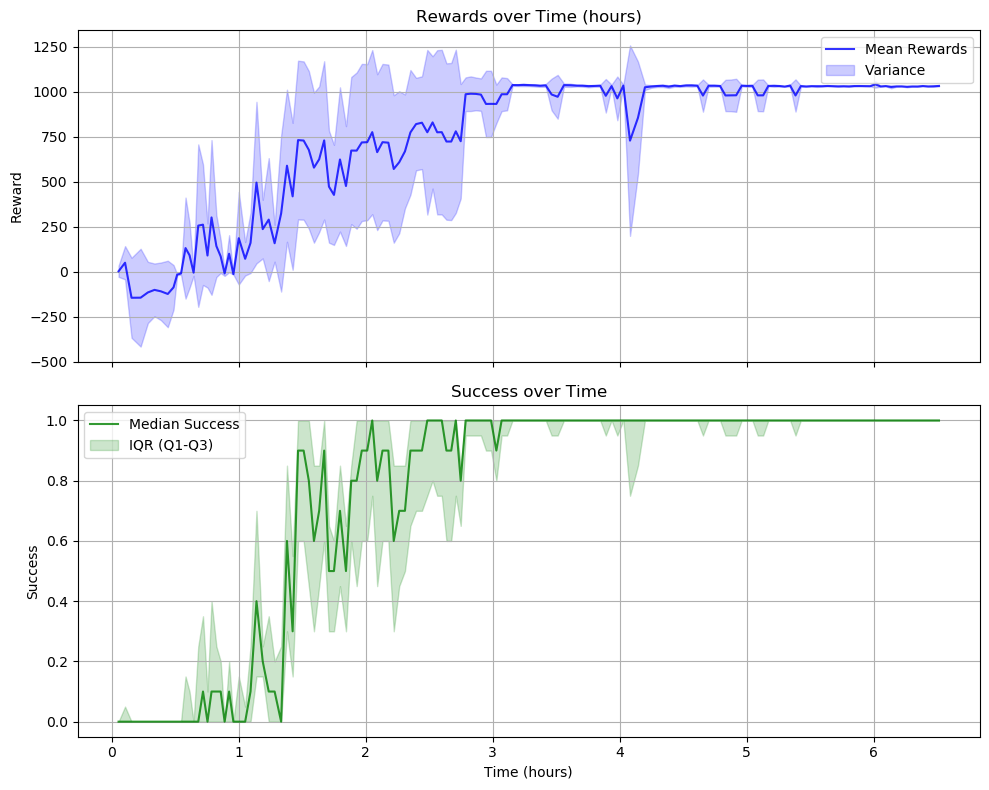

In [158]:
# Example usage

'''data_paths = [
    "./results/eval_TD3_64_128_3.npz",
    "./results/eval_TD3_64_128_2.npz",
    "./results/eval_TD3_64_128_1.npz",
    "./results/eval_TD3_64_128_0.npz"
]'''

'''data_paths = [
    "./results/eval_OurDDPG_64_128_0.npz",
    "./results/eval_OurDDPG_64_128_1.npz",
    "./results/eval_OurDDPG_64_128_2.npz",
    "./results/eval_OurDDPG_64_128_3.npz",
]'''

data_paths = [
    "./results/eval_ExpD3_64_128_3.npz",
    "./results/eval_ExpD3_64_128_2.npz",
    "./results/eval_ExpD3_64_128_1.npz",
    "./results/eval_ExpD3_64_128_0.npz"
]

# Create plotter instance
plotter = DataPlotter(data_paths[:4])
# Load and plot data

plotter.load_data(fixed_time_limit=40)
plotter.plot_evaluation_data(save_path='./images/evaluation_plot_eval_ExpD3_64_128_0.png')
#plotter.plot_evaluation_data(save_path='./images/evaluation_plot_eval_TD3_64_128_0123.png')
# plotter.plot_evaluation_data(save_path='./images/evaluation_plot_' + data_paths[1][15:-6] + '.png')